# Cardiac Signals DS Pipeline Example Run
The following script runs through the bulk of the data science pipeline.
However, since autoencoder training can take up to 15 minutes, the script defaults to loading a pretrained model and creating the reconstruction from that model. 

If you want to train the model yourself, uncomment the bottom cell to train the autoencoder directly from the preprocessed data

### IMPORTANT
To use the pretrained model, download the contents of the Box folder `PATIENT 16 PRETRAINED MOELS` into the `Working_Data` directory. The file can be found at the following [box link](https://rice.app.box.com/folder/136025997108)


### Required Preliminary Step: Make the virtual Environment and start it

Example installation of a virtual environment and installing project requirements:\
`pip install virtualenv`\
`virtualenv venv`\
`source venv/bin/activate`\
`pip install -r requirements.txt`\
`python -m ipykernel install --user --name=venv`\
In the jupyter notebook, go to Kernel, change kernel, and select the venv.

In [1]:
# Perform peak detection and filtering on the raw ECG leads
# Saves out a series of files, including Fixed_Dim_HBs_Idx16.npy
from src.preprocessing.heartbeat_split import preprocess_sum
patient_index = 16
preprocess_sum("Reference_idx_16_Time_block_1.h5", patient_index, beats_per_datapoint = 10)

Opening file : Reference_idx_16_Time_block_1.h5


In [2]:
# Normalizes the heartbeat vectors for the autoencoder
from src.preprocessing.normalize_heartbeats import normalize_heartbeats
normalize_heartbeats(patient=patient_index)

Normalized patient 16


In [3]:
# Loads the pretrained model and generate (and save) the reconstructions of the normalized heartbeats
from src.models.cdae_timedelay import *
from keras.models import load_model

print("Starting training on patient ", patient_index)
filepath = "Working_Data/Normalized_Fixed_Dim_HBs_Idx" + str(patient_index) + ".npy"
split_ratio = 0.3
train_, remaining = patient_split_adaptive(filepath, split_ratio)
# train_noise = noise(train_)
three, four, five, six = split(remaining, 4)
first_predict = np.concatenate((train_, three, four))
second_train = noise(three)
third_train = noise(four)
predict_data = [first_predict, five, six]


for iteration, pred_data in zip([0,1,2], predict_data):
    autoencoder = load_model(f'Working_Data/CDAE_timedelay_{patient_index}_iter{iteration}.h5')
    reconstruction = autoencoder.predict(pred_data)
    reconstruction_save = "Working_Data/reconstructed_10hb_cdae_" + str(patient_index) + "_iter" + str(
        iteration) + ".npy"
    np.save(reconstruction_save, reconstruction)
    print(f"Completed the {iteration} iteration of transfer learning")



Starting training on patient  16
Completed the 0 iteration of transfer learning
Completed the 1 iteration of transfer learning
Completed the 2 iteration of transfer learning


In [4]:
from src.models.changepoint import cusum
from src.models.mse import kl_divergence_timedelay

calculating KL div. time delay for file index 16 on the reconstructed cdae model


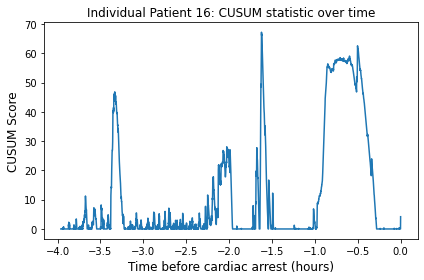

In [5]:
# compute the mean squared error of the reconstruction vs original heartbeats and apply the CUSUM changepoint algorithm
cusum_signal = cusum(16, "cdae", 100, kl_divergence_timedelay,plot=True)

The previous graph is the CUSUM error metric in the four hours preceding the cardiac arrest for patient 16

## Training autoencoder and generate intermediate data

In [6]:
# Uncomment the following section if you want to train the autoencoder rather than loading the pretrained model
# Warning: Training takes ~10 minutes, so pretrained model is offered for execution speed

# from src.models.cdae_timedelay import train_model
# # Trains the autoencoder over patient 16's normalized heartbeat and generates the heartbeat reconstruction
# train_model(patient_index)

Starting training on patient  16
Epoch 1/110
7/7 [==============================] - 3s 259ms/step - loss: 0.9715
Epoch 2/110
7/7 [==============================] - 2s 258ms/step - loss: 0.6866